## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)# 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)# 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3  # 學習率
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024  # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.05,0.5,0.99,]
redice_lr_patient = [5,10,15]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, # 學習速率被降低的因數。新的學習速率=學習速率*因數
                              min_lr=1e-12, # 學習速率的下邊界。
                              monitor='val_loss', # 被監測的數據
                              patience=reduce_patient, # 沒有進步的訓練輪數，在這之後訓練速率會被降低
                              verbose=1)  # 訊息展示模式，0或1。0：安静，1：更新信息。
    
    model.fit(x_train, y_train, # 訓練資料。
              epochs=EPOCHS, # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test), # 驗證資料。
              shuffle=True,# 每次epochs後，將訓練集打亂順序。
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.05, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.7624 - accuracy: 0.1325 - val_loss: 2.2955 - val_accuracy: 0.1261
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.3969 - accuracy: 0.2159 - val_loss: 2.2318 - val_accuracy: 0.1512
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 2.2374 - accuracy: 0.2562 - val_loss: 2.1650 - val_accuracy: 0.2024
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.1404 - accuracy: 0.2834 - val_loss: 2.1000 - val_accuracy: 0.2418
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0719 - accuracy: 0.3023 - val_loss: 2.0426 - val_accuracy: 0.2748
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0185 - accuracy: 0.3158 - val_loss: 1.9995 - val_accuracy: 0.2906
Epoch 7/25
50000/50000 [==============================] - 2s 38us/st

Epoch 21/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6972 - accuracy: 0.4084 - val_loss: 1.7800 - val_accuracy: 0.3867
Epoch 22/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6870 - accuracy: 0.4112 - val_loss: 1.7724 - val_accuracy: 0.3911
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6777 - accuracy: 0.4163 - val_loss: 1.7651 - val_accuracy: 0.3919
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6676 - accuracy: 0.4183 - val_loss: 1.7579 - val_accuracy: 0.3940
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6596 - accuracy: 0.4211 - val_loss: 1.7532 - val_accuracy: 0.3974
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0408 - accuracy: 0.3037 - val_loss: 2.0163 - val_accuracy: 0.2831
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9998 - accuracy: 0.3160 - val_loss: 1.9828 - val_accuracy: 0.2973
Epoch 8/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9662 - accuracy: 0.3249 - val_loss: 1.9613 - val_accuracy: 0.3114
Epoch 9/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9350 - accuracy: 0.3345 - val_loss: 1.9416 - val_accuracy: 0.3207
Epoch 10/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.9082 - accuracy: 0.3432 - val_loss: 1.9276 - val_accuracy: 0.3278
Epoch 11/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8854 - accuracy: 0.3489 - val_loss: 1.9137 - val_accuracy: 0.3369
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8634 - accuracy: 0.3574 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.7359 - accuracy: 0.1516 - val_loss: 2.2547 - val_accuracy: 0.1715
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.4042 - accuracy: 0.2246 - val_loss: 2.1822 - val_accuracy: 0.2205
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.2500 - accuracy: 0.2586 - val_loss: 2.1407 - val_accuracy: 0.2403
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.1548 - accuracy: 0.2805 - val_loss: 2.0971 - val_accuracy: 0.2593
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0867 - accuracy: 0.2962 - val_loss: 2.0540 - val_accuracy: 0.2754
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.0331 - accuracy: 0.3108 - val_loss: 2.0126 - val_accuracy: 0.2922
Epoch 7/25
50000/50000 [==============================] - 2s 38us/st

50000/50000 [==============================] - 2s 40us/step - loss: 1.9539 - accuracy: 0.3319 - val_loss: 1.9899 - val_accuracy: 0.2885
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9056 - accuracy: 0.3454 - val_loss: 1.9285 - val_accuracy: 0.3100
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.8692 - accuracy: 0.3562 - val_loss: 1.8873 - val_accuracy: 0.3277
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.8396 - accuracy: 0.3655 - val_loss: 1.8525 - val_accuracy: 0.3416
Epoch 8/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.8146 - accuracy: 0.3725 - val_loss: 1.8304 - val_accuracy: 0.3567
Epoch 9/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7937 - accuracy: 0.3786 - val_loss: 1.8185 - val_accuracy: 0.3631
Epoch 10/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7740 - accuracy: 0.3854 - val_loss: 1.8065 - va

Epoch 9/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7847 - accuracy: 0.3821 - val_loss: 1.7981 - val_accuracy: 0.3705
Epoch 10/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7649 - accuracy: 0.3877 - val_loss: 1.7868 - val_accuracy: 0.3739
Epoch 11/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7479 - accuracy: 0.3928 - val_loss: 1.7774 - val_accuracy: 0.3806
Epoch 12/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7308 - accuracy: 0.3972 - val_loss: 1.7731 - val_accuracy: 0.3805
Epoch 13/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7163 - accuracy: 0.4016 - val_loss: 1.7644 - val_accuracy: 0.3841
Epoch 14/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7037 - accuracy: 0.4072 - val_loss: 1.7597 - val_accuracy: 0.3856
Epoch 15/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.6910 - accuracy: 0.4110 - val_l

Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.4458 - accuracy: 0.2079 - val_loss: 2.2471 - val_accuracy: 0.1434
Epoch 2/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.1054 - accuracy: 0.2886 - val_loss: 2.1703 - val_accuracy: 0.1792
Epoch 3/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9977 - accuracy: 0.3158 - val_loss: 2.0824 - val_accuracy: 0.2270
Epoch 4/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9349 - accuracy: 0.3353 - val_loss: 2.0047 - val_accuracy: 0.2685
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.8893 - accuracy: 0.3497 - val_loss: 1.9391 - val_accuracy: 0.3019
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.8539 - accuracy: 0.3598 - val_loss: 1.88

Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.3615 - accuracy: 0.2286 - val_loss: 2.2535 - val_accuracy: 0.1964
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.2780 - accuracy: 0.2487 - val_loss: 2.2035 - val_accuracy: 0.2228
Epoch 6/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.2100 - accuracy: 0.2658 - val_loss: 2.1456 - val_accuracy: 0.2500
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.1541 - accuracy: 0.2798 - val_loss: 2.1003 - val_accuracy: 0.2719
Epoch 8/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.1053 - accuracy: 0.2932 - val_loss: 2.0617 - val_accuracy: 0.2927
Epoch 9/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.0635 - accuracy: 0.3044 - val_loss: 2.0305 - val_accuracy: 0.3048
Epoch 10/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.0275 - accuracy: 0.3141 - val_loss: 

Epoch 9/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.0487 - accuracy: 0.3034 - val_loss: 2.0082 - val_accuracy: 0.2966
Epoch 10/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.0159 - accuracy: 0.3132 - val_loss: 1.9945 - val_accuracy: 0.3049
Epoch 11/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9869 - accuracy: 0.3216 - val_loss: 1.9818 - val_accuracy: 0.3117
Epoch 12/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.9607 - accuracy: 0.3297 - val_loss: 1.9711 - val_accuracy: 0.3185
Epoch 13/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9363 - accuracy: 0.3369 - val_loss: 1.9620 - val_accuracy: 0.3239
Epoch 14/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9148 - accuracy: 0.3429 - val_loss: 1.9522 - val_accuracy: 0.3287
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8952 - accuracy: 0.3494 - val_l

_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.8377 - accuracy: 0.1303 - val_loss: 2.3142 - val_accuracy: 0.1224
Epoch 2/25
50000/50000 [==============================] - 2s 42us/step - loss: 2.5945 - accuracy: 0.1721 - val_loss: 2.2743 - val_accuracy: 0.1616
Epoch 3/25
50000/50000 [==============================] - 2s 42us/step - loss: 2.4383 - accuracy: 0.2058 - val_loss: 2.2331 - val_accuracy: 0.1788
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.3288 - accuracy: 0.2323 - val_loss: 2.1840 - val_accuracy: 0.2029
Epoch 5/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.2471 - accuracy: 0.2510 - val_loss: 2.1309 - val_accuracy: 0.2335
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 2.1804 - accuracy: 0.2682 - val_loss: 2.0862 - val_accuracy: 0.2591
Ep

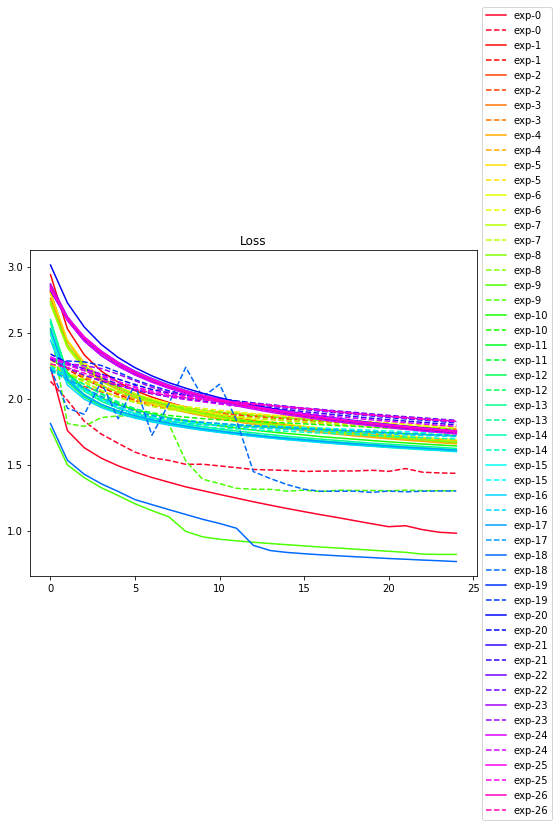

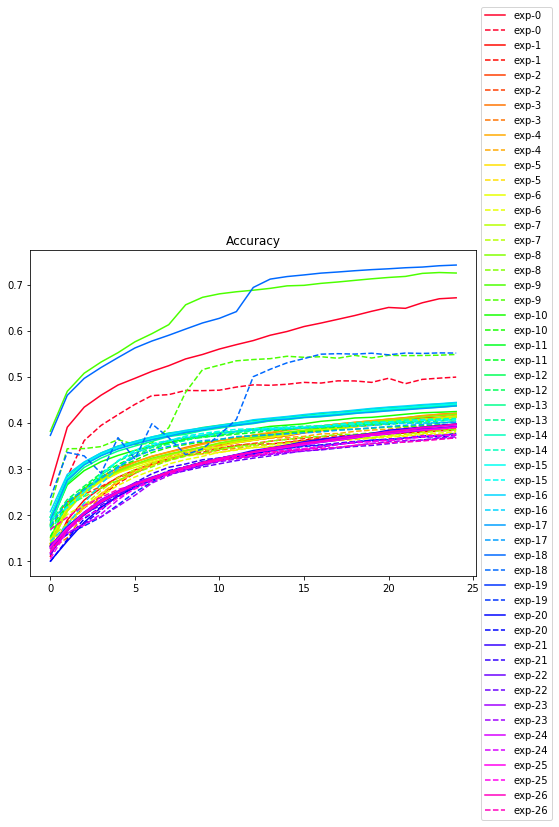

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()